# L'enjeux de ce Tp est d'entrainer un reseau de neuronnes et une OLS regression sur un dataset afin de prédire la consommation d'une voiture (MPG) compte tenu des variables explicatives suivantes : le nombre de cylindres, la puissance du moteur, le poids du véhicule, l'acceleration, l'âge du modele etc 

In [1]:
#INSTALLATION DES FRAMEWORK SEABORN ET TENSORFLOW
#use seaborn for pairplot #Librairies Graphique
!pip install -q seaborn
#Use some functions from tensorflow_docs
!pip install -q git+https://github.com/tensorflow/docs

    Running setup.py install for tensorflow-docs ... done
  DEPRECATION: tensorflow-docs was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


In [2]:
# Import de tensorflow_docs
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [3]:
# Import de tensorflow et keras 
#(partie permettant d'utiliser tensorflow sans utiiser de librairies complexes)
import tensorflow as tf
from tensorflow import keras
#Dans tf, on récupère la liste de device sur la machine
for d in tf.config.list_physical_devices(device_type=None):
  print('device found[{1}] : {0}'.format(d.name, d.device_type))
#Info sur la Version de Tensorflow
print('tensorflow version {0}'.format(tf.__version__))

device found[CPU] : /physical_device:CPU:0
device found[GPU] : /physical_device:GPU:0
tensorflow version 2.6.0


In [4]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [5]:
#Import des librairies nécessaires

from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

#Solution Graphique 
import matplotlib.pyplot as plt
#Base de Mathématiques sur Python
import numpy as np
#Solution Graphique (DataFrame)
import pandas as pd
#Solution Graphique
import seaborn as sns

DATASET MANAGEMENT

In [6]:
#On récupère le dataset puis on le charge
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

40960/30286 [========================================] - 0s 3us/step


'/root/.keras/datasets/auto-mpg.data'

In [7]:
#On rajoute un Header (Titre des colonnes)
column_names = ['MPG', 'Cylinders','Displacement','Horsepower','Weight',
                'Acceleration','Model Year', 'Origin']

# MPG représente la consommation du véhicule ( miles per gallon)

#On défini comment faire apparaitre les valeurs vides + le séparateur              
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                          na_values = "?", comment='\t',
                        sep=" ", skipinitialspace = True)

dataset = raw_dataset.copy()
#On fait apparaître les 10 dernières valeurs du fichiers
dataset.tail(10)

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
388,26.0,4,156.0,92.0,2585.0,14.5,82,1
389,22.0,6,232.0,112.0,2835.0,14.7,82,1
390,32.0,4,144.0,96.0,2665.0,13.9,82,3
391,36.0,4,135.0,84.0,2370.0,13.0,82,1
392,27.0,4,151.0,90.0,2950.0,17.3,82,1
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [8]:
#Fais apparaître les valeurs manquantes
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [9]:
#dropna : supprime toutes les lignes où il y a une valeur vide
dataset = dataset.dropna()

In [10]:
#Fais apparaître les données statistiques primaires du dataset
dataset.describe()

#Featurisation : comment transformer les données pour en extraire un maximum de valeurs 
# Ici, l'origine du véhicule nous est donné avec un rendu pas pertinent

#Ce genre de fonction est fondamental pour faire une expertise, un tas d'information
#peuvent en être extraites => Ex la voiture la plus ancienne date de 1970, la plus 
#récente date de 1982. 50% des véhicules date d'avant 1973. 

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,23.445918,5.471939,194.411990,104.469388,2977.584184,15.541327,75.979592,1.576531
std,7.805007,1.705783,104.644004,38.491160,849.402560,2.758864,3.683737,0.805518
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.000000,4.000000,105.000000,75.000000,2225.250000,13.775000,73.000000,1.000000
50%,22.750000,4.000000,151.000000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,275.750000,126.000000,3614.750000,17.025000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


In [11]:
#Comment gérer les données temporelles ?
#On transforme la donnée temporelle des dates en âge afin qu'elle soit quantitative
from datetime import datetime
year = datetime.now().year

dataset['Model Year'] = dataset['Model Year'] + 1900

In [12]:
#L'âge du véhicule est égale à Notre Année (donc year) - Date de sortie
#On ajoute une nouvelle colonne 'Model Age' au Dataframe 
#On se débarasse de Model Year
dataset['Model Age'] = year - dataset['Model Year']
dataset.pop('Model Year')
dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Origin,Model Age
0,18.0,8,307.0,130.0,3504.0,12.0,1,51
1,15.0,8,350.0,165.0,3693.0,11.5,1,51
2,18.0,8,318.0,150.0,3436.0,11.0,1,51
3,16.0,8,304.0,150.0,3433.0,12.0,1,51
4,17.0,8,302.0,140.0,3449.0,10.5,1,51


In [13]:
dataset[dataset.Origin==1].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,245.0,20.033469,6.440384,9.0,15.0,18.5,24.0,39.0
Cylinders,245.0,6.277551,1.655996,4.0,4.0,6.0,8.0,8.0
Displacement,245.0,247.512245,98.376347,85.0,151.0,250.0,318.0,455.0
Horsepower,245.0,119.048980,39.897790,52.0,88.0,105.0,150.0,230.0
Weight,245.0,3372.489796,795.346690,1800.0,2720.0,3381.0,4055.0,5140.0
Acceleration,245.0,14.990204,2.736020,8.0,13.0,15.0,16.7,22.2
Origin,245.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
Model Age,245.0,45.408163,3.660368,39.0,43.0,45.0,48.0,51.0


In [14]:
#Création d'une map
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset.dtypes

MPG             float64
Cylinders         int64
Displacement    float64
Horsepower      float64
Weight          float64
Acceleration    float64
Origin           object
Model Age         int64
dtype: object

In [15]:
#On a remplacé la valeur numérique par la correspondance du dictionnaire en texte
dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Origin,Model Age
0,18.0,8,307.0,130.0,3504.0,12.0,USA,51
1,15.0,8,350.0,165.0,3693.0,11.5,USA,51
2,18.0,8,318.0,150.0,3436.0,11.0,USA,51
3,16.0,8,304.0,150.0,3433.0,12.0,USA,51
4,17.0,8,302.0,140.0,3449.0,10.5,USA,51


In [16]:
#dataset['Origin'] = dataset['Origin'].map({1: 'USA',2: 'Europe', 3: 'Japan'})

#On va dummifier la variable Origin => classification
#La fonction a reconnu Origin car c'est le seul type object

dataset= pd.get_dummies(dataset, prefix= '', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Age,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,39,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,39,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,39,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,39,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,39,0,0,1


In [17]:
#Une fois le Dataset préparé,
#on crée le dataset d'apprentissage et de test à partir de ces données

#On sépare en Train/Test set. Méthode sample pour séparer.
#On supprime toutes les données du Train DataSet pour le Test Dataset
train_dataset = dataset.sample(frac=0.8, random_state=12345)
test_dataset = dataset.drop(train_dataset.index)

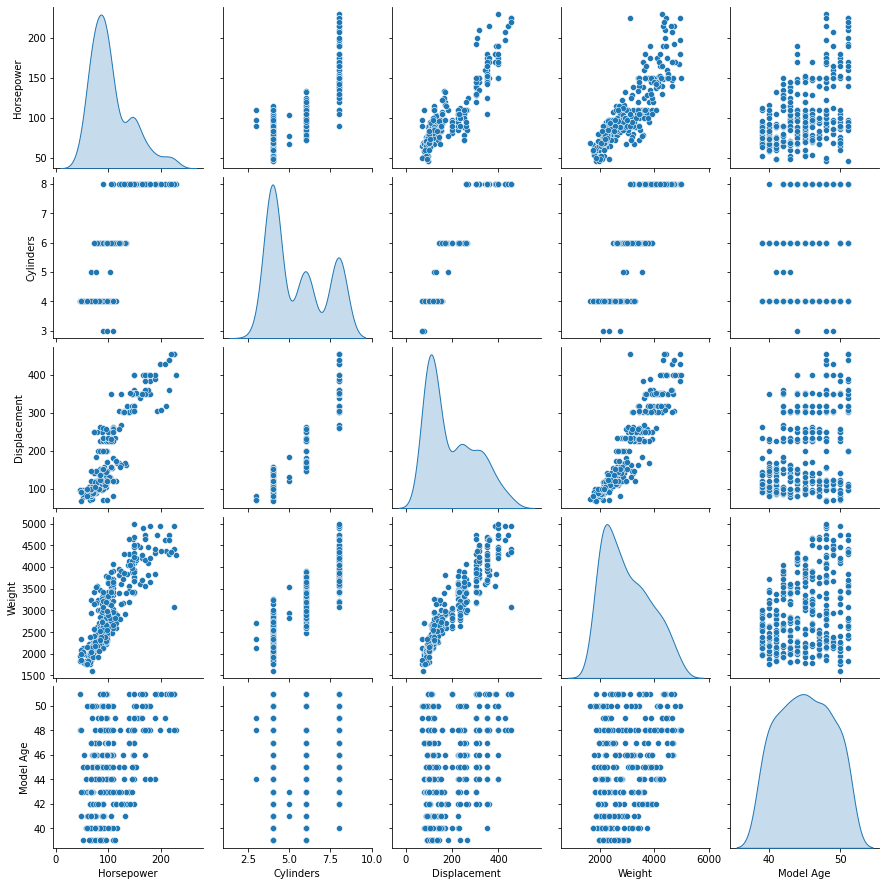

In [18]:
#Pairplot : Graphique croisée entre chaque variable
sns.pairplot(train_dataset[['Horsepower', 'Cylinders', 'Displacement', 'Weight', 'Model Age']], diag_kind = 'kde')

In [19]:
#Colonne ci-dessus : Distribution de Puissance en fonction de l'âge du véhicule

Préparation de la Modélisation 

In [20]:
train_dataset.head(6)

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Age,Europe,Japan,USA
69,12.0,8,350.0,160.0,4456.0,13.5,49,0,0,1
204,32.0,4,85.0,70.0,1990.0,17.0,45,0,1,0
156,16.0,8,400.0,170.0,4668.0,11.5,46,0,0,1
337,32.4,4,107.0,72.0,2290.0,17.0,41,0,1,0
386,25.0,6,181.0,110.0,2945.0,16.4,39,0,0,1
56,26.0,4,91.0,70.0,1955.0,20.5,50,0,0,1


In [21]:
#A partir du Train Dataset, on crée un tableau mémorisant ces statistiques pour chaque variable
# On va normaliser/standardiser les variables
#On se débarasse de la variable MPG 
train_stats = train_dataset.describe()
train_stats.pop('MPG')
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.490446,1.703662,3.0,4.00,4.0,8.000,8.0
Displacement,314.0,195.947452,105.279779,68.0,105.00,151.0,293.250,455.0
Horsepower,314.0,104.767516,39.365171,46.0,75.00,95.0,125.000,230.0
Weight,314.0,2983.047771,850.072307,1613.0,2223.75,2811.0,3627.500,4997.0
Acceleration,314.0,15.551911,2.767684,8.0,13.90,15.5,17.175,24.6
Model Age,314.0,45.022293,3.660882,39.0,42.00,45.0,48.000,51.0
Europe,314.0,0.171975,0.377961,0.0,0.00,0.0,0.000,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.000,1.0
USA,314.0,0.630573,0.483420,0.0,0.00,1.0,1.000,1.0


In [22]:
#on récupère les labels (la variable MPG)
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

In [23]:
#Création de deux fonctions, l'une permettant de normaliser le dataset (l'écart à la moyenne diviser par l'écart-type)
def norm(x):
  return (x - train_stats['mean'])/ train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

# l'autre de standardiser (mettre à l'échelle la variable en utilisant son max)
def stand(x):
  return (x*1.0 / train_stats['max'])

#On l'applique à nos deux jeux de données
stand_train_data = stand(train_dataset)
stand_test_data = stand(test_dataset)

In [24]:
#Tout a été ramené à une échelle entre 0 et 1
#On a une distribution centrée réduite autour de 0-1

stand_train_data

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Age,Europe,Japan,USA
69,1.00,0.769231,0.695652,0.891735,0.548780,0.960784,0.0,0.0,1.0
204,0.50,0.186813,0.304348,0.398239,0.691057,0.882353,0.0,1.0,0.0
156,1.00,0.879121,0.739130,0.934160,0.467480,0.901961,0.0,0.0,1.0
337,0.50,0.235165,0.313043,0.458275,0.691057,0.803922,0.0,1.0,0.0
386,0.75,0.397802,0.478261,0.589354,0.666667,0.764706,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
261,0.75,0.567033,0.521739,0.682409,0.613821,0.843137,0.0,0.0,1.0
290,1.00,0.771429,0.617391,0.811287,0.581301,0.823529,0.0,0.0,1.0
229,1.00,0.879121,0.782609,0.844507,0.451220,0.862745,0.0,0.0,1.0
173,0.50,0.261538,0.421739,0.509306,0.691057,0.901961,0.0,1.0,0.0


In [25]:

train_labels

69     12.0
204    32.0
156    16.0
337    32.4
386    25.0
       ... 
261    18.1
290    15.5
229    16.0
173    24.0
174    18.0
Name: MPG, Length: 314, dtype: float64

**SINGLE NEURONE OLS**

In [26]:
#Place au RDN
# On veut porduire une régression linéaire multiple (OLS) => y = a1x1 + a2x2 + a3xx3 etc... + b
# OLS => 1 neurone connecté à chacune des entrées
#On va passer par un Gradient et itérer pour trouver la meilleure valeur des poids et de la constante
#On va faire un learning rate pour obtenir ce résultat

#On utilise Keras pour manipuler un modèle sous tensorflow
#On import Layers 
from keras import layers

In [27]:
#Couche de Neurones Standard = Sequential => elles sont traitées l'une après l'autre en traversant le RdN couches après couches
#On aura besoin que d'une couche dans laquelle on mettra un Neurone = Dense (1) avec une fonction d'activation 'linear' 
#Et une Taille d'entrée égale à la longueur du TrainSet normalisé -1 (on retire car une des trois modalités des Régions d'origine car 
#on veut une constante qui sera porté par le biais)

# La fonction shape sert à préciser le nombre de variables

def build_model():
  model = keras.Sequential([
    layers.Dense(1, activation='linear', input_shape=[len(stand_train_data.keys()) -1])
    ])

#Deuxième étape, je définis quel est mon optimizer => RMSprop (correspond à une régression) et on lui donne un learning rate


  optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.2) #On peut changer le learning rate

# On demande à Keras de compiler le modèle (compile). On a la fonction de perte MSE. 
#On y ajoute une metrics MAE en plus de MSE pour traquer l'apprentissage

  model.compile(loss='mse',
              optimizer=optimizer,
              metrics=['mae','mse'])
  return model

#On peut relancer la fonction pour faire un nouvel apprentissage

In [28]:
#On cherche à minimiser l'erreur => sortie du Réseau de Neurones par rapport à la vraie valeur calculable avec la MSE.

with tf.device('/device:CPU:0'):
  model = build_model()
  model.summary()

#Ici, on voit que nous avons une couche d'1 Neurone avec 9 paramètres à optimiser

#En relançant la fonction, la version change

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 9         
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________


In [29]:
#On passe à l'apprentissage
#On a retiré une des variables région


#Le paramètre va passer 1500 fois dans le réseau 
EPOCHS = 1500
REPORTSTEP = 420
DOTS = 5

with tf.device('/device:CPU:0'):

  history = model.fit(
  stand_train_data[['Cylinders', 'Displacement','Horsepower','Weight','Acceleration','Model Age','Japan','USA']],
  train_labels,
  epochs=EPOCHS, validation_split = 0.1, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots(report_every=REPORTSTEP,dot_every=DOTS)])
  #fonction modeling de tfdocs pour pouvoir avoir l'avancement de mon apprentissage
  #Il mettra à jour les statistiques tout les 500 step et affichera tous les petits points tout les 5 step
  
  #On arrive à une loss autour de 12, Une erreur moyenne (MAE) à 2.66 en fin de cycle 
  
  #Nouveaux modèle avec un report tous 100 sur 800 itérations

# On a deux jeux de données ici, la donnée sur l'apprentissage et la donnée sur la validation (10% du TrainSet)


Epoch: 0, loss:354.3789,  mae:15.9974,  mse:354.3789,  val_loss:239.0924,  val_mae:12.7668,  val_mse:239.0924,  
....................................................................................
Epoch: 420, loss:12.5842,  mae:2.7041,  mse:12.5842,  val_loss:13.4539,  val_mae:2.8028,  val_mse:13.4539,  
....................................................................................
Epoch: 840, loss:11.9681,  mae:2.6258,  mse:11.9681,  val_loss:12.1617,  val_mae:2.6691,  val_mse:12.1617,  
....................................................................................
Epoch: 1260, loss:11.8581,  mae:2.6439,  mse:11.8581,  val_loss:11.6593,  val_mae:2.5624,  val_mse:11.6593,  
................................................

In [30]:
#objet de Tensorflow contenant l'historique de l'apprentissage
history 

Text(0, 0.5, 'mse [MPG]')

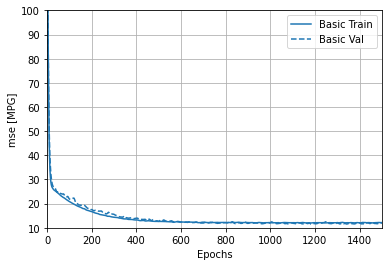

In [31]:
#On va pouvoir utiliser history pour tracer la courbe d'apprentissage et l'analyser 

# La courbe a chuté très vite (learning rate trop fort) et on voit qu'on plafonne des Epochs 500 à 1500 
# => trop d'itération/Epoch 
#

#Plot mse curve through learning steps
plotter = tfdocs.plots.HistoryPlotter(smoothing_std = 2)
plotter.plot({'Basic': history}, metric = 'mse')
plt.ylim([10, 100])
plt.xlim([0, 1500])
plt.ylabel('mse [MPG]')

In [32]:
#Get Regression Estimates

#On peut accéder au poids et au biais via cette boucle 
#On a les 8 poids 

#En relançant le modèle (à partir de la définition des itérations, les poids et le biais continue d'être ajusté)

for layer in model.layers:
  print('weights : {0}'.format(layer.get_weights()[0]))
  print('biases : {0}'.format(layer.get_weights()[1]))

weights : [[ -2.1962404 ]
 [  9.700414  ]
 [ -2.8983762 ]
 [-33.949936  ]
 [  3.841842  ]
 [-40.12573   ]
 [  0.77896965]
 [ -2.2927177 ]]
biases : [77.75845]


OLS Estimate (statsmodel)

In [33]:
#Modèle OLS : produit matricielle donnant directement le résultat des coefficients minimisant la MSE
# Import de statsmodels pour faire ça 

import statsmodels.api as sm

#On déclare nos variables pour en afficher la liste 
#On ajoute également une constante
#On demande au modèle de calculer les coefficients et d'afficher les résultats de la RL

X = stand_train_data[['Cylinders','Displacement','Horsepower','Weight','Acceleration', 'Model Age', 'Japan', 'USA']]
X = sm.add_constant(X)


model = sm.OLS(train_labels, X, hasconst = True)
results = model.fit()
print(results.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


                            OLS Regression Results                            
Dep. Variable:                    MPG   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     173.2
Date:                Wed, 25 Aug 2021   Prob (F-statistic):          1.26e-108
Time:                        09:26:01   Log-Likelihood:                -828.93
No. Observations:                 314   AIC:                             1676.
Df Residuals:                     305   BIC:                             1710.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           78.7534      3.637     21.651   

In [34]:
#Constante estimé à 78 / Pour chaque variable un coefficient mathématiques a été calculé, statistiques que donne la RL

#Probabilité de significativité du test de Student, le seuil de rejet de la variable

# Les Variables calculées par l'OLS sont assez proches de celles du RdN

#

In [35]:
from statsmodels.tools import eval_measures
print('OLS MSE value : {0}'.format(eval_measures.mse(train_labels, results.predict(X), axis=0)))

#MSE à 11.49, meilleure estimation que le modèle peut obtenir sur ces données
#MSE => écart entre les labels et la prédiction total

OLS MSE value : 11.495283803660966


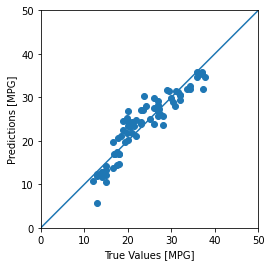

In [36]:
#On trace la courbe des erreurs 

Xtest = sm.add_constant(stand_test_data[['Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model Age', 'Japan', 'USA']])
test_predictions = results.predict(Xtest)

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
plt.plot(lims, lims)

#####LEARN A MORE COMPLEX MODEL

In [37]:
#Sur le même Dataset, on va rajouter plus de couches et plus de neurones
#Modèle Séquentielle car les données passent de couche en couche avec une 
#Première couche de 64 neurones, activation de type linéaire
#Deuxième couche de 32 neurones, de type relu (plate puis linéaire pour les valeurs positives)
#relu accélère l'apprentissage + on sait qu'il ne peut y avoir de valeur négative
#Sortie sur un neurone de type Dense qui donnera l'estimation


def build_model():
   model = keras.Sequential([
     layers.Dense(128, activation='linear', input_shape=[len(train_dataset.keys())]),
     layers.Dense(64, activation='relu'),
     layers.Dense(1)
  ])

   optimizer = tf.keras.optimizers.RMSprop(0.001)

#optimizer : mécanisme utilisé pour optimiser la Descente de Gradient

   model.compile(loss='mse',
                 optimizer=optimizer,
                 metrics=['mae','mse'])
   return model

In [38]:
#On a 97 neurones pour 2.753 paramètres, à chaque fois 1 poids et 8 varaibles en entrée
# multiplié par 64 et par 32

model_3L = build_model()
model_3L.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               1280      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 9,601
Trainable params: 9,601
Non-trainable params: 0
_________________________________________________________________


In [39]:
example_batch = normed_train_data[:10]
example_result = model_3L.predict(example_batch)
example_result

#Calcul pour s'assurer que le modèle fonctionne => on prend le TrainSet et on lui demande un predict de 10 lignes
#Ici rien n'est encore entraîné

array([[-0.17884633],
       [ 0.4638591 ],
       [-0.08737183],
       [ 0.6295529 ],
       [ 0.25389865],
       [ 0.33287707],
       [-0.0385353 ],
       [ 0.54021865],
       [ 0.22017476],
       [-0.40396944]], dtype=float32)

In [40]:
#On fait tourner l'apprentissage sur ce nouveau modèle à multiples neurones

EPOCHS = 1000

history = model_3L.fit(
  stand_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])

#Avec un réseau plus complexe que les précédents, l'apprentissage permet de descendre plus bas dans le Gradient
#On trouve donc quelque chose de plus précis car on donne la possibilité de détecter des relations non linéaires dans ce modèle


Epoch: 0, loss:553.7311,  mae:22.0806,  mse:553.7311,  val_loss:532.6760,  val_mae:21.5033,  val_mse:532.6760,  
....................................................................................................
Epoch: 100, loss:20.4744,  mae:3.4496,  mse:20.4744,  val_loss:25.1408,  val_mae:4.1961,  val_mse:25.1408,  
....................................................................................................
Epoch: 200, loss:14.4443,  mae:2.8322,  mse:14.4443,  val_loss:17.3077,  val_mae:3.3239,  val_mse:17.3077,  
....................................................................................................
Epoch: 300, loss:9.2993,  mae:2.2196,  mse:9.2993,  val_loss:12.5034,  val_mae:2.6248,  val_mse:12.5034,  
....................................................................................................
Epoch: 400, loss:8.4656,  mae:2.1263,  mse:8.4656,  val_loss:10.2992,  val_mae:2.5473,  val_mse:10.2992,  
..................................................

In [41]:
#On visualise le DataFrame

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
0,553.731140,22.080606,553.731140,532.675964,21.503328,532.675964,0
1,442.160126,19.263493,442.160126,417.707977,18.491278,417.707977,1
2,332.356628,15.942913,332.356628,306.614319,14.963448,306.614319,2
3,233.516312,12.463714,233.516312,210.842697,11.637380,210.842697,3
4,160.531006,10.109363,160.531006,148.411087,9.594723,148.411087,4
...,...,...,...,...,...,...,...
995,7.480995,1.900782,7.480995,11.470689,2.891199,11.470689,995
996,7.528618,2.026173,7.528618,9.004008,2.361182,9.004008,996
997,7.465834,1.955394,7.465834,10.854452,2.785497,10.854452,997
998,7.472930,1.928034,7.472930,8.994048,2.396028,8.994048,998
